In [1]:
# colab에서 실행

In [2]:
import os
import sys
import gzip
import random
import platform
import warnings
import collections
from tqdm import tqdm, tqdm_notebook

In [3]:
import re
import requests
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.datasets import load_iris

In [4]:
import torch
import torchtext
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, utils

In [5]:
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
os.makedirs('data', exist_ok=True)

In [8]:
# Set random seed
SEED = 2021
random.seed(SEED)
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)  # type: ignore
torch.backends.cudnn.deterministic = True  # type: ignore
torch.backends.cudnn.benchmark = True  # type: ignore

In [9]:
# 현재 OS 및 라이브러리 버전 체크 체크
current_os = platform.system()
print(f"Current OS: {current_os}")
print(f"CUDA: {torch.cuda.is_available()}")
print(f"Python Version: {platform.python_version()}")
print(f"torch Version: {torch.__version__}")
print(f"torchvision Version: {torchvision.__version__}")

# 중요하지 않은 에러 무시
warnings.filterwarnings(action='ignore')

# 유니코드 깨짐현상 해결
mpl.rcParams['axes.unicode_minus'] = False

Current OS: Linux
CUDA: False
Python Version: 3.7.12
torch Version: 1.10.0+cu111
torchvision Version: 0.11.1+cu111


# PyTorch DL steps
```python
# 모델 생성
model = CustomNet()
model.train() # ?

# 옵티마이저 정의
params = [param for param in model.parameters() if param.requires_grad]
optimizer = optim.Example(params, lr=lr) # ?

# 손실함수 정의
loss_fn = ExampleLoss()

# Dataset & DataLoader
dataset_example = ExampleDataset()
dataloader_example = DataLoader(dataset_example)

# Transfer learning & Hyperparameter tuning
for e in range(epochs):
    for X, y in dataloader_example:
        output = model(X)
        loss = loss_fn(output, y) # loss 기록
        optimizer.zero_grad() # ?
        loss.backward() # backprop
        optimizer.step()
```

# PyTorch Dataset

In [10]:
# Dataset을 구성할 때는 torch.utils.data에서 Dataset 클래스를 상속해서 만듦.

```python
# map-style dataset의 구조

from torch.utils.data import Dataset

class CustomDataset(Dataset):
    # 초기화 작업
    # 데이터를 불러옴
    def __init__(self,):
        pass
      
    def __len__(self):
        pass

    # 데이터셋의 idx번째 데이터를 반환함
    def __getitem__(self, idx):
        pass
```

In [11]:
iris = load_iris()
# iris['data']
# iris['feature_names']
# iris['target']
iris_df = pd.DataFrame(iris['data'], columns=iris['feature_names'])
iris_df['target'] = iris['target']
iris_df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


In [12]:
# iris dataset

class IrisDataset(Dataset):
    def __init__(self):
        iris = load_iris()

        self.X = iris['data'] # iris에 어떤 항목들이 있는지는 어떻게 확인?
        self.y = iris['target']

        self.feature_names = iris['feature_names']
        self.target_names = iris['target_names']

    def __len__(self):
        return len(self.X)
      
    def __getitem__(self, idx):
        X = torch.tensor(self.X[idx], dtype=torch.float)
        y = torch.tensor(self.y[idx], dtype=torch.long)
        return X, y

In [13]:
dataset_iris = IrisDataset()

In [14]:
len(dataset_iris)

150

In [15]:
dataset_iris[0]

(tensor([5.1000, 3.5000, 1.4000, 0.2000]), tensor(0))

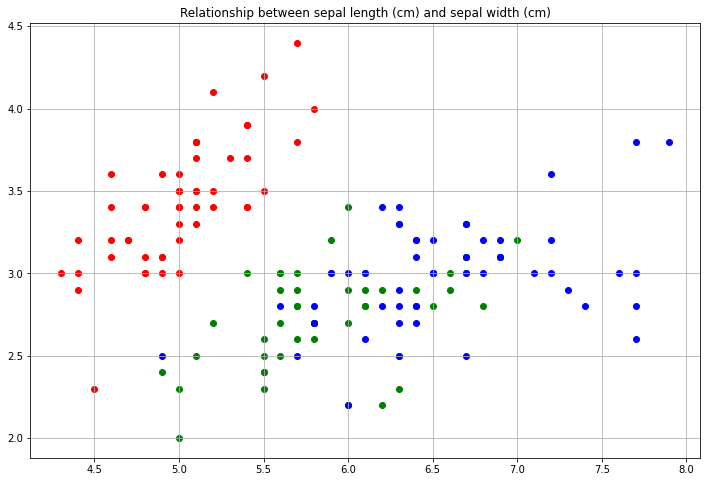

In [16]:
plt.figure(figsize=(12,8))
colors = ['r','g','b']
for n, c in enumerate(dataset_iris.y):
    plt.scatter(dataset_iris.X[n,0], dataset_iris.X[n,1], color=colors[c])
plt.title('Relationship between {} and {}'.format(dataset_iris.feature_names[0],
                                                  dataset_iris.feature_names[1]))
plt.grid(True)
plt.show()

# PyTorch DataLoader

```python
DataLoader(dataset, batch_size=1, shuffle=False, sampler=None,
           batch_sampler=None, num_workers=0, collate_fn=None,
           pin_memory=False, drop_last=False, timeout=0,
           worker_init_fn=None)
```

In [17]:
# batch-size

next(iter(DataLoader(dataset_iris, batch_size=4)))

[tensor([[5.1000, 3.5000, 1.4000, 0.2000],
         [4.9000, 3.0000, 1.4000, 0.2000],
         [4.7000, 3.2000, 1.3000, 0.2000],
         [4.6000, 3.1000, 1.5000, 0.2000]]), tensor([0, 0, 0, 0])]

In [18]:
# shuffle

next(iter(DataLoader(dataset_iris, shuffle=True, batch_size=4)))

[tensor([[4.9000, 3.0000, 1.4000, 0.2000],
         [6.1000, 3.0000, 4.6000, 1.4000],
         [5.6000, 2.9000, 3.6000, 1.3000],
         [6.2000, 3.4000, 5.4000, 2.3000]]), tensor([0, 1, 1, 2])]

In [19]:
# sampler

# index를 컨트롤하는 방법임
# 따라서 shuffle=False 이어야

In [20]:
# num_workers

# 데이터를 불러올 때 사용하는 subprocess의 개수

In [21]:
# collate_fn

# sample list를 batch 단위로 바꿀 때 데이터 사이즈를 맞추기 위해 사용

In [22]:
class ExampleDataset(Dataset):
    def __init__(self, num):
        self.num = num
    
    def __len__(self):
        return self.num
    
    def __getitem__(self, idx):
        return {"X":torch.tensor([idx] * (idx+1), dtype=torch.float32), 
                "y": torch.tensor(idx, dtype=torch.float32)}

In [23]:
dataset_example = ExampleDataset(10)

In [24]:
dataloader_example = torch.utils.data.DataLoader(dataset_example)
for d in dataloader_example:
    print(d)

{'X': tensor([[0.]]), 'y': tensor([0.])}
{'X': tensor([[1., 1.]]), 'y': tensor([1.])}
{'X': tensor([[2., 2., 2.]]), 'y': tensor([2.])}
{'X': tensor([[3., 3., 3., 3.]]), 'y': tensor([3.])}
{'X': tensor([[4., 4., 4., 4., 4.]]), 'y': tensor([4.])}
{'X': tensor([[5., 5., 5., 5., 5., 5.]]), 'y': tensor([5.])}
{'X': tensor([[6., 6., 6., 6., 6., 6., 6.]]), 'y': tensor([6.])}
{'X': tensor([[7., 7., 7., 7., 7., 7., 7., 7.]]), 'y': tensor([7.])}
{'X': tensor([[8., 8., 8., 8., 8., 8., 8., 8., 8.]]), 'y': tensor([8.])}
{'X': tensor([[9., 9., 9., 9., 9., 9., 9., 9., 9., 9.]]), 'y': tensor([9.])}


In [25]:
def my_collate_fn(samples):

    collate_X = []
    collate_y = []

    max_len = max([len(sample['X']) for sample in samples])

    print()
    for sample in samples:
        print(sample)
    # samples: mini-batch 하나
    # sample: mini-batch 중 데이터 하나

    for sample in samples:
        diff = max_len-len(sample['X'])
        
        print(diff)

        if diff > 0:
            zero_pad = torch.zeros(size=(diff,))
            collate_X.append(torch.cat([sample['X'], zero_pad], dim=0))
        else:
            collate_X.append(sample['X'])
    
    collate_y = [sample['y'] for sample in samples]

    return {'X': torch.stack(collate_X),
            'y': torch.stack(collate_y)}

In [26]:
dataloader_example = torch.utils.data.DataLoader(dataset_example, 
                                                 batch_size=2,
                                                 collate_fn=my_collate_fn)
for d in dataloader_example:
    print(d)


{'X': tensor([0.]), 'y': tensor(0.)}
{'X': tensor([1., 1.]), 'y': tensor(1.)}
1
0
{'X': tensor([[0., 0.],
        [1., 1.]]), 'y': tensor([0., 1.])}

{'X': tensor([2., 2., 2.]), 'y': tensor(2.)}
{'X': tensor([3., 3., 3., 3.]), 'y': tensor(3.)}
1
0
{'X': tensor([[2., 2., 2., 0.],
        [3., 3., 3., 3.]]), 'y': tensor([2., 3.])}

{'X': tensor([4., 4., 4., 4., 4.]), 'y': tensor(4.)}
{'X': tensor([5., 5., 5., 5., 5., 5.]), 'y': tensor(5.)}
1
0
{'X': tensor([[4., 4., 4., 4., 4., 0.],
        [5., 5., 5., 5., 5., 5.]]), 'y': tensor([4., 5.])}

{'X': tensor([6., 6., 6., 6., 6., 6., 6.]), 'y': tensor(6.)}
{'X': tensor([7., 7., 7., 7., 7., 7., 7., 7.]), 'y': tensor(7.)}
1
0
{'X': tensor([[6., 6., 6., 6., 6., 6., 6., 0.],
        [7., 7., 7., 7., 7., 7., 7., 7.]]), 'y': tensor([6., 7.])}

{'X': tensor([8., 8., 8., 8., 8., 8., 8., 8., 8.]), 'y': tensor(8.)}
{'X': tensor([9., 9., 9., 9., 9., 9., 9., 9., 9., 9.]), 'y': tensor(9.)}
1
0
{'X': tensor([[8., 8., 8., 8., 8., 8., 8., 8., 8., 0.],
     

In [27]:
# pin_memory

# True일 경우 Tensor를 CUDA 고정 메모리에 할당

In [28]:
# drop_last

# 마지막 mini-batch 무시

In [29]:
# time_out

# DataLoader가 data를 불러올 때 제한시간 설정

In [30]:
# worker_init_fn

# 어떤 worker를 불러올 것인가를 리스트로 전달

# torchvision transform functions

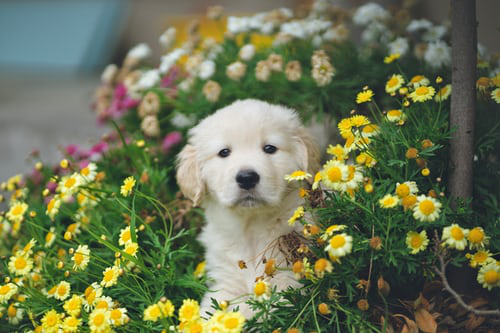

In [31]:
url = 'https://images.unsplash.com/photo-1583160247711-2191776b4b91?ixid=MnwxMjA3fDB8MHxzZWFyY2h8MTN8fGdvbGRlbnJldHJpZXZlcnxlbnwwfHwwfHw%3D&ixlib=rb-1.2.1&auto=format&fit=crop&w=500&q=60'
im = Image.open(requests.get(url, stream=True).raw)  # torchvision은 항상 PIL 객체로 받아야합니다!
im

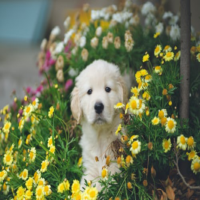

In [32]:
im = torchvision.transforms.Resize((200, 200))(im)
im

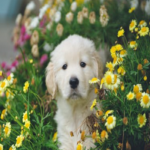

In [33]:
def get_transforms_img(im):
  im = transforms.Resize((200, 200))(im)
  im = transforms.CenterCrop(150)(im)
  return im

im = get_transforms_img(im)
im

In [34]:
# transforms.ToTensor()

transforms.ToTensor()(im)

tensor([[[0.4314, 0.4314, 0.4314,  ..., 0.3804, 0.3255, 0.4000],
         [0.4314, 0.4314, 0.4353,  ..., 0.4706, 0.4235, 0.4588],
         [0.4314, 0.4353, 0.4353,  ..., 0.5333, 0.5059, 0.5020],
         ...,
         [0.8824, 0.9098, 0.7922,  ..., 0.1804, 0.1843, 0.1843],
         [0.8745, 0.8784, 0.7725,  ..., 0.1804, 0.1686, 0.1569],
         [0.8510, 0.8510, 0.7137,  ..., 0.1608, 0.1490, 0.1451]],

        [[0.5882, 0.5882, 0.5882,  ..., 0.4314, 0.3882, 0.4549],
         [0.5882, 0.5882, 0.5922,  ..., 0.5216, 0.4863, 0.5137],
         [0.5882, 0.5922, 0.5922,  ..., 0.5804, 0.5647, 0.5569],
         ...,
         [0.7686, 0.8549, 0.7961,  ..., 0.1725, 0.1765, 0.1647],
         [0.7059, 0.7843, 0.7961,  ..., 0.1647, 0.1608, 0.1529],
         [0.6627, 0.7725, 0.7451,  ..., 0.1529, 0.1490, 0.1451]],

        [[0.6353, 0.6353, 0.6353,  ..., 0.4314, 0.3686, 0.4431],
         [0.6353, 0.6353, 0.6392,  ..., 0.5176, 0.4667, 0.5020],
         [0.6353, 0.6392, 0.6392,  ..., 0.5647, 0.5451, 0.

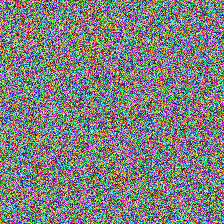

In [35]:
# transforms.ToPILImage()

im_arr = torch.rand((3, 224, 224))
im_pil = transforms.ToPILImage()(im_arr)
im_pil

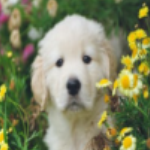

In [36]:
transforms.Compose([transforms.Resize((224,224)),
                    transforms.CenterCrop(150)])(im)

In [37]:
dir(transforms)

['AutoAugment',
 'AutoAugmentPolicy',
 'CenterCrop',
 'ColorJitter',
 'Compose',
 'ConvertImageDtype',
 'FiveCrop',
 'GaussianBlur',
 'Grayscale',
 'InterpolationMode',
 'Lambda',
 'LinearTransformation',
 'Normalize',
 'PILToTensor',
 'Pad',
 'RandAugment',
 'RandomAdjustSharpness',
 'RandomAffine',
 'RandomApply',
 'RandomAutocontrast',
 'RandomChoice',
 'RandomCrop',
 'RandomEqualize',
 'RandomErasing',
 'RandomGrayscale',
 'RandomHorizontalFlip',
 'RandomInvert',
 'RandomOrder',
 'RandomPerspective',
 'RandomPosterize',
 'RandomResizedCrop',
 'RandomRotation',
 'RandomSizedCrop',
 'RandomSolarize',
 'RandomVerticalFlip',
 'Resize',
 'Scale',
 'TenCrop',
 'ToPILImage',
 'ToTensor',
 'TrivialAugmentWide',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'autoaugment',
 'functional',
 'functional_pil',
 'functional_tensor',
 'transforms']

# torchvision Dataset

In [38]:
dataset_train_MNIST = torchvision.datasets.MNIST('data/MNIST/', # 다운로드 경로 지정
                                                 train=True, # True를 지정하면 훈련 데이터로 다운로드
                                                 transform=transforms.ToTensor(), # 텐서로 변환
                                                 download=True, 
                                                )

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/MNIST/raw



In [39]:
dataset_train_MNIST

Dataset MNIST
    Number of datapoints: 60000
    Root location: data/MNIST/
    Split: Train
    StandardTransform
Transform: ToTensor()

In [40]:
len(dataset_train_MNIST)

60000

In [41]:
dataset_train_MNIST.classes

# dataset.classes로 classes 확인
# !

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [42]:
image, label = next(iter(dataset_train_MNIST))
image, label

# next, iter로 feed한 다음에 확인
# !

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [43]:
# pd df로 보여주기

pd.DataFrame(np.int32(image.numpy()[0]*255)).style.set_properties(**{'font-size':'5pt'}).background_gradient(axis=None)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,3,18,18,18,126,136,175,26,166,255,247,127,0,0,0,0
6,0,0,0,0,0,0,0,0,30,36,94,154,170,253,253,253,253,253,225,172,253,242,195,64,0,0,0,0
7,0,0,0,0,0,0,0,49,238,253,253,253,253,253,253,253,253,251,93,82,82,56,39,0,0,0,0,0
8,0,0,0,0,0,0,0,18,219,253,253,253,253,253,198,182,247,241,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,80,156,107,253,253,205,11,0,43,154,0,0,0,0,0,0,0,0,0,0


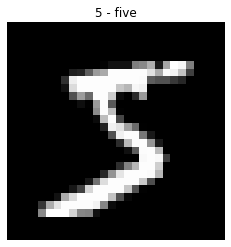

In [44]:
# plt로 보여주기

plt.imshow(image.numpy().squeeze(), cmap='gray')
plt.title("{}".format(dataset_train_MNIST.classes[label]))
plt.axis('off')
plt.show()

In [45]:
# DataLoader

dataloader_train_MNIST = DataLoader(dataset=dataset_train_MNIST,
                                    batch_size=16,
                                    shuffle=True,
                                    num_workers=4,
                                   )

In [46]:
images, labels = next(iter(dataloader_train_MNIST))

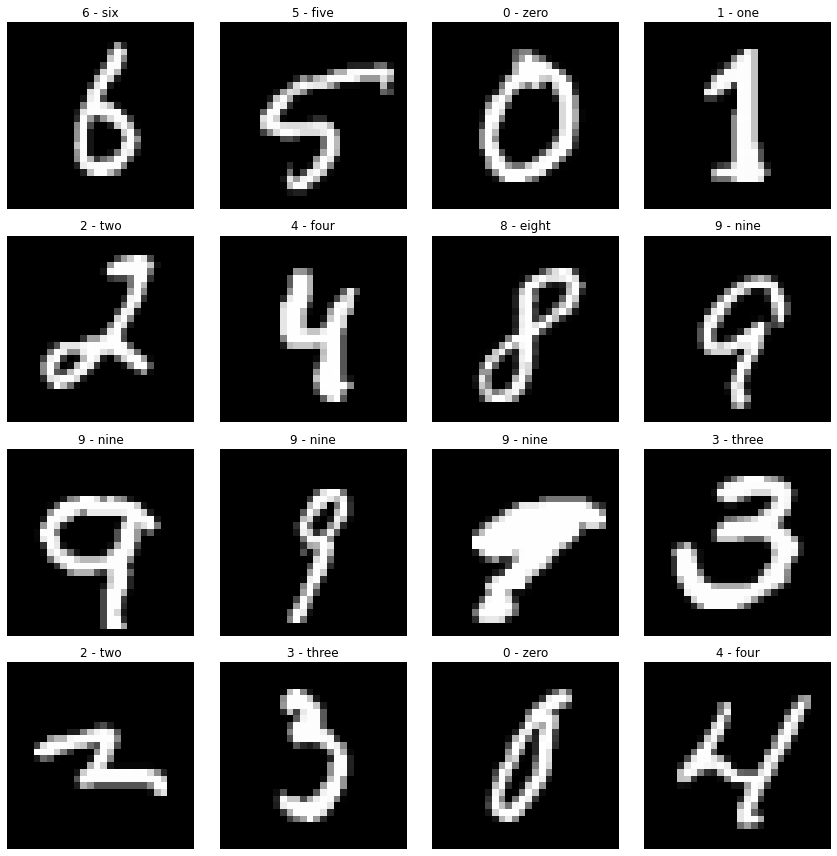

In [47]:
# batch-size 16

plt.figure(figsize=(12,12))

# enumerate( , start=1)
for n, (image, label) in enumerate(zip(images, labels), start=1):
    plt.subplot(4,4,n)
    plt.imshow(image.numpy().squeeze(), cmap='gray')
    plt.title("{}".format(dataset_train_MNIST.classes[label]))
    plt.axis('off')
plt.tight_layout()
plt.show()    

In [48]:
# CIFAR10

dataset_train_CIFAR10 = torchvision.datasets.CIFAR10(root='data/CIFAR10/',  # 다운로드 경로 지정
                                                     train=True,  # True를 지정하면 훈련 데이터로 다운로드
                                                     transform=transforms.Compose([
                                                         transforms.RandomHorizontalFlip(),
                                                         transforms.ToTensor(),
                                                         transforms.Normalize((0.5, 0.5, 0.5), 
                                                                              (0.5, 0.5, 0.5))
                                                     ]),  # 텐서로 변환
                                                     download=True,
                                                     )

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/CIFAR10/cifar-10-python.tar.gz to data/CIFAR10/


In [49]:
dataset_train_CIFAR10

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data/CIFAR10/
    Split: Train
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [50]:
len(dataset_train_CIFAR10)

50000

In [51]:
dataset_train_CIFAR10.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [52]:
image, label = next(iter(dataset_train_CIFAR10))
image, label

(tensor([[[ 0.1608,  0.1922,  0.2392,  ..., -0.6078, -0.6627, -0.5373],
          [-0.0431, -0.0667, -0.0353,  ..., -0.8588, -1.0000, -0.8745],
          [-0.1451, -0.0588, -0.0745,  ..., -0.6157, -0.8745, -0.8039],
          ...,
          [-0.5843, -0.5608,  0.2549,  ...,  0.5529,  0.5765,  0.6314],
          [-0.3490, -0.2392,  0.4431,  ...,  0.4588,  0.3569,  0.4118],
          [-0.0353,  0.1843,  0.6941,  ...,  0.4039,  0.3176,  0.3882]],
 
         [[-0.0275, -0.0196,  0.0353,  ..., -0.6235, -0.6392, -0.5137],
          [-0.3176, -0.3490, -0.3098,  ..., -0.9373, -1.0000, -0.8431],
          [-0.4275, -0.3412, -0.3412,  ..., -0.7882, -0.9451, -0.8118],
          ...,
          [-0.7333, -0.7569,  0.0431,  ...,  0.2627,  0.2000,  0.3333],
          [-0.5843, -0.5137,  0.1608,  ...,  0.1294, -0.0353,  0.0902],
          [-0.2784, -0.0745,  0.4431,  ...,  0.1137,  0.0118,  0.1294]],
 
         [[-0.1922, -0.2000, -0.1529,  ..., -0.6627, -0.6471, -0.5059],
          [-0.5529, -0.6078,

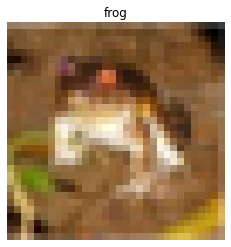

In [53]:
plt.imshow(transforms.ToPILImage()(image*0.5+0.5))  # Normalize 처리때문에 복구
plt.title("{}".format(dataset_train_CIFAR10.classes[label]))
plt.axis('off')
plt.show()

In [54]:
# DataLoader

dataloader_train_CIFAR10 = DataLoader(dataset=dataset_train_CIFAR10,
                                      batch_size=16,
                                      shuffle=True,
                                      num_workers=4,
                                      )

In [55]:
images, labels = next(iter(dataloader_train_CIFAR10))

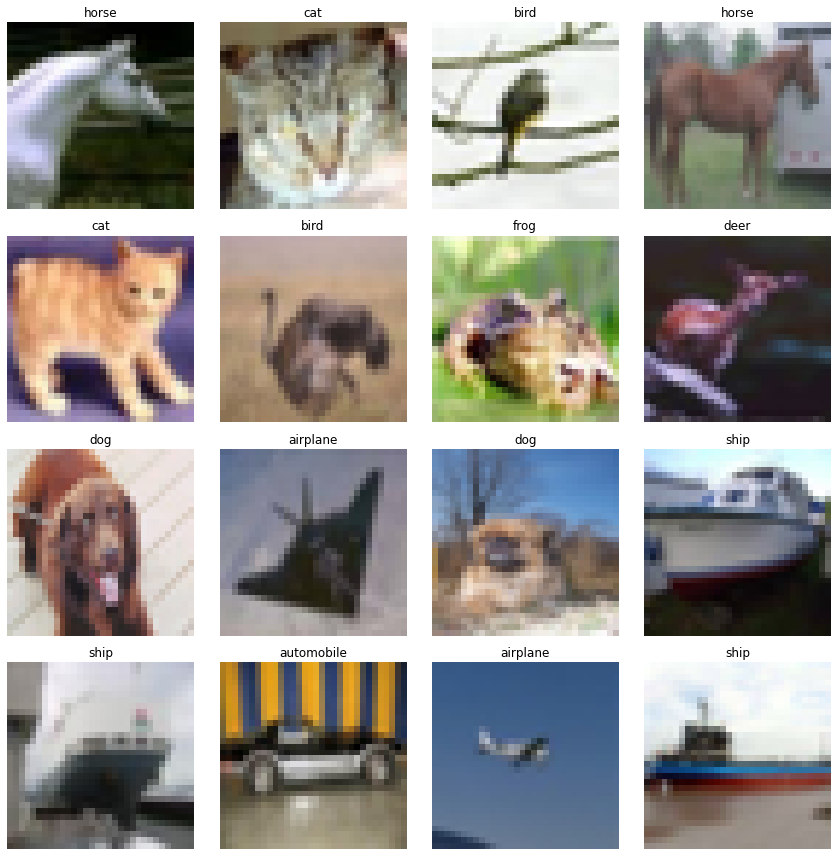

In [56]:
# batch-size 16

plt.figure(figsize=(12,12))
for n, (image, label) in enumerate(zip(images, labels), start=1):
    plt.subplot(4,4,n)
    plt.imshow(transforms.ToPILImage()(image*0.5+0.5))  # Normalize 처리때문에 복구
    plt.title("{}".format(dataset_train_CIFAR10.classes[label]))
    plt.axis('off')
plt.tight_layout()
plt.show()    

In [57]:
dir(torchvision.datasets)

['CIFAR10',
 'CIFAR100',
 'Caltech101',
 'Caltech256',
 'CelebA',
 'Cityscapes',
 'CocoCaptions',
 'CocoDetection',
 'DatasetFolder',
 'EMNIST',
 'FakeData',
 'FashionMNIST',
 'Flickr30k',
 'Flickr8k',
 'HMDB51',
 'INaturalist',
 'ImageFolder',
 'ImageNet',
 'KMNIST',
 'Kinetics',
 'Kinetics400',
 'Kitti',
 'LFWPairs',
 'LFWPeople',
 'LSUN',
 'LSUNClass',
 'MNIST',
 'Omniglot',
 'PhotoTour',
 'Places365',
 'QMNIST',
 'SBDataset',
 'SBU',
 'SEMEION',
 'STL10',
 'SVHN',
 'UCF101',
 'USPS',
 'VOCDetection',
 'VOCSegmentation',
 'VisionDataset',
 'WIDERFace',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'caltech',
 'celeba',
 'cifar',
 'cityscapes',
 'coco',
 'fakedata',
 'flickr',
 'folder',
 'hmdb51',
 'imagenet',
 'inaturalist',
 'kinetics',
 'kitti',
 'lfw',
 'lsun',
 'mnist',
 'omniglot',
 'phototour',
 'places365',
 'sbd',
 'sbu',
 'semeion',
 'stl10',
 'svhn',
 'ucf101',
 'usps',
 'utils',

# torchtext Dataset

In [58]:
dataset_train_AG_NEWS, dataset_test_AG_NEWS = torchtext.datasets.AG_NEWS(root='./data')

29.5MB [00:00, 85.3MB/s]
1.86MB [00:00, 40.5MB/s]                  


In [59]:
dataset_train_AG_NEWS

In [60]:
# dataset_train_AG_NEWS.classes()
# 이거 왜 안됨??

In [61]:
len(dataset_train_AG_NEWS)

120000

In [62]:
next(iter(dataset_train_AG_NEWS))

(3,
 "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.")

In [63]:
classes = ['World', 'Sports', 'Business', 'Sci/Tech']

In [64]:
# tokenizer

tokenizer = torchtext.data.utils.get_tokenizer('basic_english')
tokenizer('Hello World!')

['hello', 'world', '!']

In [65]:
dataset_train_AG_NEWS = list(dataset_train_AG_NEWS)
dataset_test_AG_NEWS = list(dataset_test_AG_NEWS)

# dataset_train_AG_NEWS

In [66]:
counter = collections.Counter()
for (label, line) in dataset_train_AG_NEWS:
    # print(label, line)
    counter.update(tokenizer(line))
vocab = torchtext.vocab.vocab(counter, min_freq=1)

In [67]:
vocab_size = len(vocab)
print(f"Vocab size is {vocab_size}")

# 왜 사이즈 줄어듦?

Vocab size is 95809


In [68]:
# encode: s to i
# decode: i to s

def encode(x):
    return [vocab.get_stoi()[s] for n, s in enumerate(tokenizer(x))]

def decode(x):
    return [vocab.get_itos()[i] for n, i in enumerate(x)]

In [69]:
encode('I love to play with my words')

[598, 3278, 82, 1219, 328, 212, 7367]

In [70]:
decode(encode('I love to play with my words'))

['i', 'love', 'to', 'play', 'with', 'my', 'words']

In [71]:
# ??? 이해 못함

# CountVectorizer()
# def to_bow()
# def bowify()
# DataLoader()

# Titanic

In [72]:
!wget https://gist.githubusercontent.com/minsuk-sung/89df85781237b7e5b2bcd34e2c17c7ee/raw/3c3ceffb81f396e85bb964d8c77b5c90b681106c/train.csv -P data/titanic

--2022-02-01 14:31:29--  https://gist.githubusercontent.com/minsuk-sung/89df85781237b7e5b2bcd34e2c17c7ee/raw/3c3ceffb81f396e85bb964d8c77b5c90b681106c/train.csv
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60302 (59K) [text/plain]
Saving to: ‘data/titanic/train.csv’

train.csv           100%[===================>]  58.89K  --.-KB/s    in 0.01s   

2022-02-01 14:31:29 (5.76 MB/s) - ‘data/titanic/train.csv’ saved [60302/60302]



In [73]:
!wget https://gist.githubusercontent.com/minsuk-sung/89df85781237b7e5b2bcd34e2c17c7ee/raw/3c3ceffb81f396e85bb964d8c77b5c90b681106c/test.csv  -P data/titanic

--2022-02-01 14:31:30--  https://gist.githubusercontent.com/minsuk-sung/89df85781237b7e5b2bcd34e2c17c7ee/raw/3c3ceffb81f396e85bb964d8c77b5c90b681106c/test.csv
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28210 (28K) [text/plain]
Saving to: ‘data/titanic/test.csv’

test.csv            100%[===================>]  27.55K  --.-KB/s    in 0.002s  

2022-02-01 14:31:30 (13.2 MB/s) - ‘data/titanic/test.csv’ saved [28210/28210]



In [74]:
os.listdir('./data/titanic/')

['test.csv', 'train.csv']

In [75]:
# pandas dataframe 조작해보기

path = './data/titanic/train.csv'
data = pd.read_csv(path)
data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [76]:
type(data)

pandas.core.frame.DataFrame

In [77]:
data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [78]:
data.keys()

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [79]:
# 지정한 col만 저장

data = pd.DataFrame(data, columns=['PassengerId', 'Survived'])
data

,PassengerId,Survived
0,1,0
1,2,1
2,3,1
3,4,1
4,5,0
...,...,...
886,887,0
887,888,1
888,889,0
889,890,1


In [80]:
# dataset

class TitanicDataset(Dataset):
    def __init__(self, path, drop_features, train=True):
        
        self.data = pd.read_csv(path)

        self.data['Sex'] = self.data['Sex'].map({'male': 0, 'female': 1})
        self.data['Embarked'] = self.data['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})

        self.train = train
        
        self.data = self.data.drop(drop_features, axis=1)
        
        self.X = self.data.drop('Survived', axis=1)
        self.y = self.data['Survived']

        # tolist() function
        self.features = self.X.columns.tolist()
        self.classes = ['Dead', 'Survivied']

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        
        X = self.X.iloc[idx].values

        if self.train==True:
            y = self.y.iloc[idx]

        return torch.tensor(X), torch.tensor(y)

In [81]:
# dataset

dataset_train_titanic = TitanicDataset('./data/titanic/train.csv',
                                       drop_features=['PassengerId', 'Name', 'Ticket', 'Cabin'],
                                       train=True)

In [82]:
# features

dataset_train_titanic.features

['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']

In [83]:
# classes

dataset_train_titanic.classes

['Dead', 'Survivied']

In [84]:
next(iter(dataset_train_titanic))

(tensor([ 3.0000,  0.0000, 22.0000,  1.0000,  0.0000,  7.2500,  0.0000],
        dtype=torch.float64), tensor(0))

In [85]:
# dataloader

dataloader_train_titanic = DataLoader(dataset=dataset_train_titanic,
                                      batch_size=8,
                                      shuffle=True,
                                      num_workers=4,
                                      )

In [86]:
# features, labels

features, labels = next(iter(dataloader_train_titanic))

In [87]:
features

tensor([[ 2.0000,  0.0000,     nan,  0.0000,  0.0000, 13.8625,  1.0000],
        [ 3.0000,  0.0000, 44.0000,  0.0000,  1.0000, 16.1000,  0.0000],
        [ 3.0000,  1.0000, 30.0000,  1.0000,  1.0000, 24.1500,  0.0000],
        [ 3.0000,  0.0000,     nan,  0.0000,  0.0000,  7.2292,  1.0000],
        [ 1.0000,  1.0000, 36.0000,  0.0000,  2.0000, 71.0000,  0.0000],
        [ 3.0000,  0.0000,     nan,  1.0000,  0.0000,  7.7500,  2.0000],
        [ 2.0000,  0.0000, 23.0000,  0.0000,  0.0000, 10.5000,  0.0000],
        [ 3.0000,  0.0000, 55.5000,  0.0000,  0.0000,  8.0500,  0.0000]],
       dtype=torch.float64)

In [88]:
labels

tensor([1, 0, 0, 1, 1, 0, 0, 0])

In [89]:
# columns - csv
# features, classes - dataset

# features, labels - dataloader (arbitrarily named variables)

# MNIST

In [90]:
os.listdir('data/MNIST/MNIST/raw')

['t10k-images-idx3-ubyte',
 't10k-labels-idx1-ubyte.gz',
 'train-labels-idx1-ubyte.gz',
 't10k-images-idx3-ubyte.gz',
 't10k-labels-idx1-ubyte',
 'train-images-idx3-ubyte.gz',
 'train-images-idx3-ubyte',
 'train-labels-idx1-ubyte']

In [91]:
BASE_MNIST_PATH = 'data/MNIST/MNIST/raw'
TRAIN_MNIST_IMAGE_PATH = os.path.join(BASE_MNIST_PATH, 'train-images-idx3-ubyte.gz')
TRAIN_MNIST_LABEL_PATH = os.path.join(BASE_MNIST_PATH, 'train-labels-idx1-ubyte.gz')
TEST_MNIST_IMAGE_PATH = os.path.join(BASE_MNIST_PATH, 't10k-images-idx3-ubyte.gz')
TEST_MNIST_LABEL_PATH = os.path.join(BASE_MNIST_PATH, 't10k-labels-idx1-ubyte.gz')

In [92]:
TRAIN_MNIST_PATH = {
    'image': TRAIN_MNIST_IMAGE_PATH,
    'label': TRAIN_MNIST_LABEL_PATH
}

In [93]:
def read_MNIST_images(path):
    with gzip.open(path, 'r') as f: # gzip?
        # first 4 bytes is a magic number
        magic_number = int.from_bytes(f.read(4), 'big')
        # second 4 bytes is the number of images
        image_count = int.from_bytes(f.read(4), 'big')
        # third 4 bytes is the row count
        row_count = int.from_bytes(f.read(4), 'big')
        # fourth 4 bytes is the column count
        column_count = int.from_bytes(f.read(4), 'big')
        # rest is the image pixel data, each pixel is stored as an unsigned byte
        # pixel values are 0 to 255
        image_data = f.read()
        images = np.frombuffer(image_data, dtype=np.uint8)\
            .reshape((image_count, row_count, column_count))
        return images

def read_MNIST_labels(path):
    with gzip.open(path, 'r') as f:
        # first 4 bytes is a magic number
        magic_number = int.from_bytes(f.read(4), 'big')
        # second 4 bytes is the number of labels
        label_count = int.from_bytes(f.read(4), 'big')
        # rest is the label data, each label is stored as unsigned byte
        # label values are 0 to 9
        label_data = f.read()
        labels = np.frombuffer(label_data, dtype=np.uint8)
        return labels

In [94]:
class MyMNISTDataset(Dataset):
    def __init__(self, path, transform, train=True):

        self.path = path

        self.X = read_MNIST_images(self.path['image'])
        self.y = read_MNIST_labels(self.path['label'])

        self.classes = ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']

        self.train = train

        self.transform = transform

        self._repr_indent = 4

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):

        X = self.X[idx]
        
        if self.transform:
            X = self.transform(X)
        
        if self.train:
            y = self.y[idx]
    
        return torch.tensor(X, dtype=torch.double), torch.tensor(y, dtype=torch.long)


    def __repr__(self):

        head = "My Custom Dataset : MNIST"
        data_path = self._repr_indent*" " + "Data path: {}".format(self.path['image'])
        label_path = self._repr_indent*" " + "Label path: {}".format(self.path['label'])
        num_data = self._repr_indent*" " + "Number of datapoints: {}".format(self.__len__())
        num_classes = self._repr_indent*" " + "Number of classes: {}".format(len(self.classes))

        return '\n'.join([head,
                          data_path, label_path, 
                          num_data, num_classes])

In [95]:
# dataset 생성
# path 지정
# transforms.Compose

dataset_train_MyMNIST = MyMNISTDataset(path=TRAIN_MNIST_PATH,
                                       transform=transforms.Compose([
                                           transforms.ToTensor()
                                       ]),
                                       train=True
                                       )

In [96]:
# 그냥 call 하면 __repr__(self)에서 실행

dataset_train_MyMNIST

My Custom Dataset : MNIST
    Data path: data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz
    Label path: data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz
    Number of datapoints: 60000
    Number of classes: 10

In [97]:
len(dataset_train_MyMNIST)

60000

In [98]:
image, label = next(iter(dataset_train_MyMNIST))
image, label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [99]:
type(image)

torch.Tensor

In [100]:
# numpy()

image.numpy()

array([[[0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.

In [101]:
image.numpy().shape

(1, 28, 28)

In [102]:
# squeeze()

image.numpy().squeeze()

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.    

In [103]:
image.numpy().squeeze().shape

(28, 28)

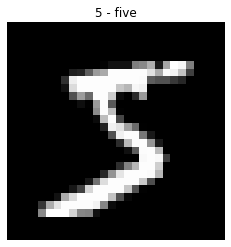

In [104]:
plt.imshow(image.numpy().squeeze(), cmap='gray')
plt.title("{}".format(dataset_train_MyMNIST.classes[label]))
plt.axis('off')
plt.show()

In [105]:
# dataloader

dataloader_train_MNIST = DataLoader(dataset=dataset_train_MyMNIST,
                                    batch_size=16,
                                    shuffle=True,
                                    num_workers=4,
                                    )

In [106]:
# with a batch size of 16

images, labels = next(iter(dataloader_train_MNIST))

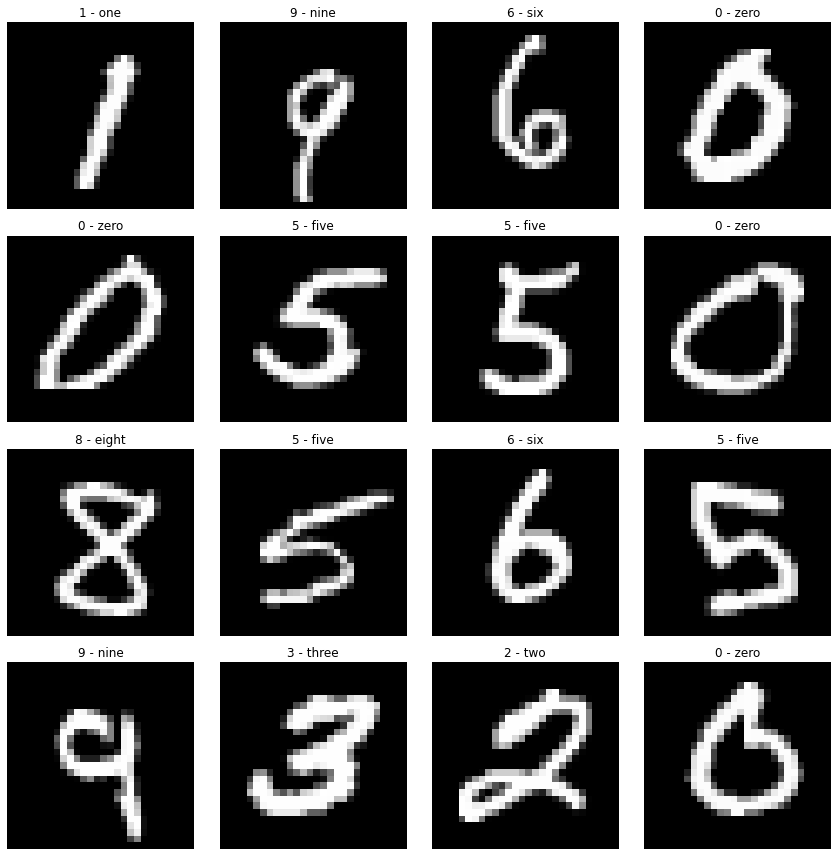

In [107]:
plt.figure(figsize=(12,12))
for n, (image, label) in enumerate(zip(images, labels), start=1):
    plt.subplot(4,4,n)
    plt.imshow(image.numpy().squeeze(), cmap='gray')
    plt.title("{}".format(dataset_train_MyMNIST.classes[label]))
    plt.axis('off')
plt.tight_layout()
plt.show()    

# AG_NEWS

In [108]:
os.listdir('data/AG_NEWS')

['test.csv', 'train.csv']

In [109]:
BASE_AG_NEWS_PATH = 'data/AG_NEWS'
TRAIN_AG_NEWS_PATH = os.path.join(BASE_AG_NEWS_PATH, 'train.csv')
TEST_AG_NEWS_PATH = os.path.join(BASE_AG_NEWS_PATH, 'test.csv')

In [110]:
class MyAG_NEWSDataset(Dataset):
    def __init__(self, path='./data/AG_NEWS/train.csv', train=True):
        
        # tqdm: 진행상황 로딩 바로 표시해줌
        tqdm.pandas()

        self.data = pd.read_csv(path, sep=',', header=None, names=['class', 'title', 'description'])

        self.path = path

        self.classes = ['World', 'Sports', 'Business', 'Sci/Tech']

        self.train = train

        self.X = (self.data['title'] + '' + self.data['description']).progress_apply(lambda s: self._preprocess(s)) # tqdm
        self.y = self.data['class']

        # list comprehension with two for loops
        self.vocab = list(set([w for s in self.X for w in s.split(' ')])) + [' ']

        self.encoder = {w:n for n,w in enumerate(self.vocab)}
        self.decoder = {n:w for n,w in enumerate(self.vocab)}

        self._repr_indent = 4

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        
        X = self.X.loc[idx]

        if self.train:
            y = self.y.loc[idx]

        return y, X

    def __repr__(self):

        head = "My Custom Dataset : AG_NEWS"
        data_path = self._repr_indent*" " + "Data path: {}".format(self.path)
        num_data = self._repr_indent*" " + "Number of datapoints: {}".format(self.__len__())
        num_classes = self._repr_indent*" " + "Number of classes: {}".format(len(self.classes))

        return '\n'.join([head, data_path, num_data, num_classes])

    def _preprocess(self, s):

        s = re.sub(r'[^A-Za-z0-9 ]+', '', s)
        s = s.lower()
        return s        


In [111]:
import numpy as np
i = 0
for i in tqdm(np.random.rand(10000000)):
    i = i**2

100%|██████████| 10000000/10000000 [00:07<00:00, 1277302.69it/s]


```python
result = []
for tag in tags:
    for entry in entries:
        if tag in entry:
            result.extend(entry)

# is equivalent with

[entry for tag in tags for entry in entries if tag in entry]
```

In [112]:
dataset_train_MyAG_NEWS = MyAG_NEWSDataset(TRAIN_AG_NEWS_PATH, train=True)

100%|██████████| 120000/120000 [00:01<00:00, 95809.20it/s]


In [113]:
dataset_train_MyAG_NEWS

My Custom Dataset : AG_NEWS
    Data path: data/AG_NEWS/train.csv
    Number of datapoints: 120000
    Number of classes: 4

In [114]:
dataset_train_MyAG_NEWS.classes

['World', 'Sports', 'Business', 'Sci/Tech']

In [115]:
len(dataset_train_MyAG_NEWS.vocab)  
# 지금은 간단한 전처리만 했으므로 값이 다를 수 있음 # <- ??? 전처리하면 길이 줄어듦?

171523

In [116]:
dataset_train_MyAG_NEWS.encoder['hello']

91731

In [117]:
next(iter(dataset_train_MyAG_NEWS))

(3,
 'wall st bears claw back into the black reutersreuters  shortsellers wall streets dwindlingband of ultracynics are seeing green again')

In [118]:
# ??? 이해 못함

# def custom_to_bow
# def custom_bowify
# DataLoader()